In [ ]:
!pip install pulp
# Import necessary libraries
import pandas as pd
import pulp

# Upload the dataset from your local machine
from google.colab import files
uploaded = files.upload()

# Load the dataset
df = pd.read_csv(next(iter(uploaded)))

# Clean column names by stripping any leading/trailing spaces
df.columns = df.columns.str.strip()

# Check the first few rows of the dataset
print(df.head())

# Define constants (example costs)
Carrying_Cost_Rate = 5  # Example carrying cost rate (as a fraction of the product price per day)
# Convert Profit Margin percentage to decimal for calculation
df['Profit Margin Decimal'] = df['Profit Margin (%)'] / 100.0

# Extract product details from the dataset
products = df['Model'].tolist()  # List of products (Models)
demand = df['Expected Demand'].tolist()  # Expected demand for each product
stock_levels = df['Sales Volume (Units)'].tolist()  # Current inventory level
reorder_levels = df['Reorder Level'].tolist()  # Reorder level

# Initialize the Linear Programming problem
prob = pulp.LpProblem("Inventory_Management_Optimization", pulp.LpMinimize)

# Decision variables: order quantities (x_i) and backorders (y_i)
x = pulp.LpVariable.dicts("Order_Quantity", range(len(products)), lowBound=0, cat='Continuous')
y = pulp.LpVariable.dicts("Backorders", range(len(products)), lowBound=0, cat='Continuous')

# Calculate holding cost per unit for each product
df['Holding Cost'] = (df['Price (INR)'] * Carrying_Cost_Rate) / 365

# Calculate backorder cost per unit for each product
df['Backorder Cost'] = df['Price (INR)'] * df['Profit Margin Decimal']

# Objective function: Minimize total cost (holding cost + backorder cost)
prob += pulp.lpSum([
    df['Holding Cost'][i] * (x[i] + stock_levels[i] - demand[i]) +
    df['Backorder Cost'][i] * y[i]
    for i in range(len(products))
]), "Total Cost"

# Constraints:
# 1. Inventory balance: Ensure stock after order meets or exceeds demand
for i in range(len(products)):
    prob += stock_levels[i] + x[i] - y[i] >= demand[i], f"Inventory_Balance_{i}"

# 2. Reorder level: Order quantity must meet or exceed reorder level
for i in range(len(products)):
    prob += stock_levels[i] + x[i] >= reorder_levels[i], f"Reorder_Level_{i}"

# 3. Backorders must not be negative
for i in range(len(products)):
    prob += y[i] >= 0, f"NonNegative_Backorders_{i}"

# Solve the problem
prob.solve()

# Display the results
print("Optimization Results ---")
order_quantities = {}
backorders = {}
for i in range(len(products)):
    order_quantity = pulp.value(x[i])
    backorder_quantity = pulp.value(y[i])
    order_quantities[products[i]] = order_quantity
    backorders[products[i]] = backorder_quantity
    print(f"Product: {products[i]}, Order Quantity: {order_quantity:.2f}, Backorders: {backorder_quantity:.2f}")

# You can store the order quantities and backorders in a DataFrame for further analysis
results_df = pd.DataFrame(list(order_quantities.items()), columns=['Product', 'Order Quantity'])
results_df['Backorders'] = results_df['Product'].map(backorders)
results_df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 81.1 MB/s eta 0:00:00


Saving SSmobile.csv to SSmobile.csv
     Brand              Model Category  Price (INR)  Expected Demand  \
0     Oppo    Oppo Reno 7 Pro   Budget        40361              106   
1   Xiaomi      Redmi Note 12   Budget        24968               77   
2   Xiaomi      Redmi Note 11   Budget        19904              106   
3   Xiaomi  Redmi Note 12 Pro   Budget        28729              448   
4  OnePlus         OnePlus 9R   Budget        38771              446   

   Discount (%)  Supplier Lead Time (Days)  Sales Volume (Units)  \
0            12                         30                    95   
1            14                         18                    69   
2            15                          7                    95   
3            16                         45                   404   
4            10                         15                   402   

   Reorder Level  Restocking Cost (INR)  Profit Margin (%)  \
0            106                   2747                 21  

,Product,Order Quantity,Backorders
0,Oppo Reno 7 Pro,21.0,0.0
1,Redmi Note 12,35.0,0.0
2,Redmi Note 11,36.0,0.0
3,Redmi Note 12 Pro,37.0,0.0
4,OnePlus 9R,43.0,0.0


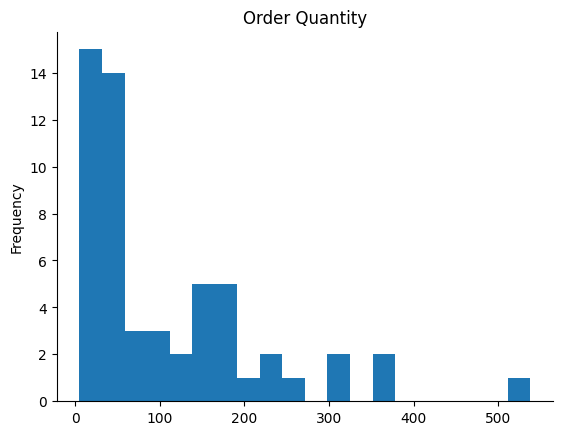

In [ ]:
# @title Order Quantity

from matplotlib import pyplot as plt
results_df['Order Quantity'].plot(kind='hist', bins=20, title='Order Quantity')
plt.gca().spines[['top', 'right',]].set_visible(False)